# Pretrained Models

# Image Retrieval

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms

resnet18_model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)

modules = list(resnet18_model.children())[:-1]
resnet18_model = torch.nn.Sequential(*modules)

resnet18_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18_model.to(device)

/home/huydn/miniconda3/envs/aie/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [3]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    processed_img = transform(img)
    return processed_img

def extract_feature(processed_image):
    input = processed_image.unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = resnet18_model(input)
    return prediction.squeeze().cpu().tolist()

In [4]:
image_path = "data/images_mr/0.jpg"

processed_image = preprocess_image(image_path)
image_embedding = extract_feature(processed_image)

In [5]:
len(image_embedding)

512

In [6]:
image_embedding[0]

1.2001731395721436

##**Image Retrieval with Vector Database**

In [ ]:
# !pip install grpcio pymilvus

###**Connect a Database**

In [7]:
# connect database
from pymilvus import MilvusClient, connections

CLUSTER_ENDPOINT = "https://in03-50aaf211a5af826.api.gcp-us-west1.zillizcloud.com"
TOKEN = "543b003114e5a7cc8eafb72101acba2ffedc947f227118827be1b3f345c679b53fd375d8e31ecec33e4fe83d2760e81df693eed1"

connections.connect(
    "default",
    uri=CLUSTER_ENDPOINT,
    token=TOKEN
)

client = MilvusClient(
    uri=CLUSTER_ENDPOINT,
    token=TOKEN
)

###**Create a Collection**

In [8]:
from pymilvus import Collection, DataType, FieldSchema, CollectionSchema, utility

# create a collection
COLLECTION_NAME = "ResNet18"
check_collection = utility.has_collection(COLLECTION_NAME)
if check_collection:
    drop_result = utility.drop_collection(COLLECTION_NAME)

EMBEDDING_DIM=512
image_id = FieldSchema(
    name="image_id",
    dtype=DataType.INT64,
    is_primary=True,
    description="Image ID"
)

image_embedding = FieldSchema(
    name="image_embedding",
    dtype=DataType.FLOAT_VECTOR,
    dim=EMBEDDING_DIM
)

schema = CollectionSchema(
    fields=[image_id, image_embedding],
    auto_id=False,
    description="Image Retrieval Using ResNet18")

collection = Collection(
    name=COLLECTION_NAME,
    schema=schema
)

In [9]:
collection

<Collection>:
-------------
<name>: ResNet18
<description>: Image Retrieval Using ResNet18
<schema>: {'auto_id': False, 'description': 'Image Retrieval Using ResNet18', 'fields': [{'name': 'image_id', 'description': 'Image ID', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': False}, {'name': 'image_embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 512}}]}

###**Insert Entities**

In [10]:
image_folder = "data/images_mr"

In [11]:
import os
sorted([int(image_name.split(".")[0]) for image_name in os.listdir(image_folder)])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [12]:
from tqdm import tqdm

from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    processed_img = transform(img)
    return processed_img

def extract_feature(processed_image):
    input = processed_image.unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = resnet18_model(input)
    return prediction.squeeze().cpu().tolist()

# extract feature
image_ids = sorted([
    int(image_name.split(".")[0]) for image_name in os.listdir(image_folder)
])
image_embeddings = []
for file_name in tqdm(image_ids):
    file_name = str(file_name) + ".jpg"
    image_path = os.path.join(image_folder, file_name)
    processed_image = preprocess_image(image_path)
    processed_image = extract_feature(processed_image)
    image_embeddings.append(processed_image)

100%|██████████| 9908/9908 [04:03<00:00, 40.66it/s]


In [13]:
# insert entities
entities = [image_ids, image_embeddings]
ins_resp = collection.insert(entities)
ins_resp

(insert count: 9908, delete count: 0, upsert count: 0, timestamp: 446289135168389122, success count: 9908, err count: 0)

In [20]:
collection.flush()

###Indexing

In [21]:
collection.num_entities

9908

In [22]:
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "L2",
    "params": {}
}
collection.create_index(
    field_name=image_embedding.name,
    index_params=index_params
)

Status(code=0, message=)

In [17]:
collection.drop_index()

In [18]:
collection.has_index()

False

###Get Entities

In [25]:
res = client.get(
        collection_name=COLLECTION_NAME,
        ids=0 # [7, 17]
)
res

[{'image_id': 0,
  'image_embedding': [1.2001731,
   1.0686905,
   0.95555097,
   0.9184075,
   0.41306004,
   0.3366159,
   1.1248113,
   0.57310325,
   0.30264032,
   1.3700924,
   0.5576935,
   0.9290908,
   0.41008148,
   1.140278,
   0.09794292,
   0.8033762,
   0.05105182,
   2.2344632,
   0.22213084,
   0.079331346,
   0.032760378,
   0.55062664,
   0.7524438,
   0.58676344,
   0.29443675,
   0.48767066,
   0.15610127,
   1.511879,
   0.597856,
   0.0,
   0.8615356,
   0.4742627,
   0.013216966,
   1.1568258,
   0.0011309218,
   0.25036582,
   0.526627,
   0.45145178,
   2.449314,
   0.01090306,
   0.8759842,
   0.94606346,
   0.08888152,
   2.7259274,
   1.479417,
   1.3653331,
   0.0781813,
   0.1876967,
   0.597326,
   0.36971503,
   1.3043442,
   0.022481093,
   0.5764133,
   0.4247246,
   0.04661005,
   1.096608,
   0.3499959,
   0.82792455,
   1.2703955,
   0.13318746,
   0.0,
   0.08265327,
   0.7963929,
   0.002406792,
   0.7541133,
   0.15913716,
   0.89374775,
   0.259

###Delete Enties

In [ ]:
res = collection.delete(
    "image_id in [7, 17]"
)
res

In [ ]:
res = client.get(
    collection_name=COLLECTION_NAME,
    ids=7
)
res

###Search

In [26]:
# load collection
collection.load()

In [27]:
# search
search_params = {
    "metric_type": "L2",
    "params": {"level": 2}
}
def search_images(image_path, topk=5):
    processed_image = preprocess_image(image_path)
    processed_image = extract_feature(processed_image)
    results = collection.search(
        [processed_image],
        anns_field=image_embedding.name,
        param=search_params,
        limit=topk,
        guarantee_timestamp=1
    )
    return results[0]

In [28]:
def display_image(image_path):
    image = Image.open(image_path).convert('RGB')
    display(image)

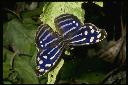

In [29]:
image_path = "data/query_img/q1.jpg"
display_image(image_path)

In [30]:
results = search_images(image_path)
results

['id: 20, distance: 0.0016687080496922135, entity: {}', 'id: 31, distance: 167.30870056152344, entity: {}', 'id: 7, distance: 189.01768493652344, entity: {}', 'id: 1123, distance: 192.01797485351562, entity: {}', 'id: 57, distance: 195.010986328125, entity: {}']

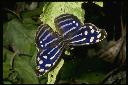

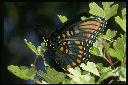

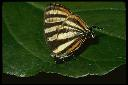

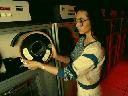

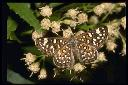

In [31]:
for result in results:
    display_image(image_folder + "/" + str(result.id) + ".jpg")